## Detect aeolian features


In [1]:
import os
import shutil
import sys
import random
import math
import re
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as pp
import matplotlib.patches as patches
from trainingImage import TrainingImage
from tqdm import tqdm

# Root directory of the project
ROOT_DIR = "/home/liorr/Mask_RCNN/mrcnn"

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import aeolian

# Import stuff for model evaluation
from xml.etree import ElementTree
from mrcnn.config import Config
from mrcnn.utils import Dataset, compute_ap
from mrcnn.model import MaskRCNN, load_image_gt, mold_image
from analyze_dune_morph import get_contours

%matplotlib inline 
%reload_ext autoreload
%autoreload 2

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [2]:
config = aeolian.AeolianConfig()
AEOLIAN_DIR = os.path.join(ROOT_DIR, "aeolian_dataset/dataset")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_CHANNEL_COUNT = 3

config = InferenceConfig()
config.display()


Configurations:
AUGMENTATION_PROB              0.5
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FIRST_LEG                      all
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  832
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [832 832   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LEARNING_RATE_1                0.001
LEARNING_RATE_2                1e-05
LEARNING_RATE_3                1e-07
LOSS_WEIGHTS              

## Notebook Preferences


In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = pp.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load validation or test dataset

In [6]:
dataset = aeolian.AeolianDataset()
# dataset.load_aeolian(AEOLIAN_DIR, "val")
dataset.load_aeolian(AEOLIAN_DIR, "test")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 50
Classes: ['BG', 'barchan_dune', 'TAR']


## Load Model


In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
    
# Set path to aeolian db weights file
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_weight_decay_0.00002_augmentation_prob_0.75_learning_rate_1e-7_20210116T2203/mask_rcnn_aeolian_weight_decay_0.00002_augmentation_prob_0.75_learning_rate_1e-7__0168.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_weight_decay_0.00002_augmentation_prob_0.5_learning_rate_1e-7_20210117T0705/mask_rcnn_aeolian_weight_decay_0.00002_augmentation_prob_0.5_learning_rate_1e-7__0166.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_weight_decay_0.00001_augmentation_prob_0.5_learning_rate_1e-7_20210116T0947/mask_rcnn_aeolian_weight_decay_0.00001_augmentation_prob_0.5_learning_rate_1e-7__0100.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_004_20210119T0744/mask_rcnn_aeolian_004__0100.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_005_20210119T1140/mask_rcnn_aeolian_005__0086.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_006_20210119T1931/mask_rcnn_aeolian_006__0074.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_007_20210120T1217/mask_rcnn_aeolian_007__0120.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_008_20210121T1034/mask_rcnn_aeolian_008__0008.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_009_20210121T1122/mask_rcnn_aeolian_009__0042.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_010_20210121T1518/mask_rcnn_aeolian_010__0080.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_011_20210122T0943/mask_rcnn_aeolian_011__0054.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_012_20210122T1449/mask_rcnn_aeolian_012__0070.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_014_20210123T1058/mask_rcnn_aeolian_014__0038.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_014_20210123T1058/mask_rcnn_aeolian_014__0055.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_015_20210125T1313/mask_rcnn_aeolian_015__0030.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_016_20210125T2041/mask_rcnn_aeolian_016__0050.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_017_20210126T1306/mask_rcnn_aeolian_017__0050.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_003_20210118T1854/mask_rcnn_aeolian_003__0002.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_018_20210201T2242/mask_rcnn_aeolian_018__0100.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_019_20210210T1521/mask_rcnn_aeolian_019__0111.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0001.h5"

AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_016_20210125T2041/mask_rcnn_aeolian_016__0113.h5"


# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
weights_path = AEOLIAN_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_016_20210125T2041/mask_rcnn_aeolian_016__0113.h5
Re-starting from epoch 113


## Evaluate model precision

In [8]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

map_list = list()

# sample_size = np.size(dataset.image_ids)
sample_size = 50

for model_idx in np.arange(1,120,2):
    model_idx_str = str(model_idx)
    model_idx_str_zeros = model_idx_str.zfill(4)
    
    AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__" + model_idx_str_zeros + ".h5"
    print(AEOLIAN_WEIGHTS_PATH)
    weights_path = AEOLIAN_WEIGHTS_PATH

    # Load weights
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)

    AP_list = list()

    for image_id in tqdm(np.random.choice(dataset.image_ids, sample_size)):

        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        info = dataset.image_info[image_id]

        # convert image into one sample
        sample = np.expand_dims(image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        r_val = {"rois": gt_bbox, "class_ids": gt_class_id, "scores": np.ones(np.shape(gt_class_id)), "masks": gt_mask}
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        AP_list.append(AP)

    #     if AP < 0.5:
    #         cnt = get_contours(image, r, True, 0.5, True)
    #         cnt = get_contours(image, r_val, True, 0.5, True, (0, 0, 255))              

        # calculate the mean AP across all images
    mAP = np.mean(AP_list)

    print(np.mean(AP_list))

    map_list.append(map)


/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0001.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0001.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 1


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


0.15510038016027805
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0003.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0003.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 3


100%|██████████| 50/50 [00:35<00:00,  1.43it/s]


0.32011294262682555
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0005.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0005.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 5


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


0.4127292143477007
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0007.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0007.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 7


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


0.37067596132318054
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0009.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0009.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 9


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


0.44074722869346433
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0011.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0011.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 11


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


0.5018186678782913
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0013.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0013.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 13


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


0.5463807066219754
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0015.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0015.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 15


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


0.5378181632601517
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0017.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0017.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 17


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


0.6344720117398724
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0019.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0019.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 19


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


0.6103404976984305
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0021.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0021.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 21


100%|██████████| 50/50 [00:28<00:00,  1.77it/s]


0.6283880334300086
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0023.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0023.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 23


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


0.5590200490547528
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0025.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0025.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 25


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


0.598467265096675
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0027.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0027.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 27


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


0.6710851877715447
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0029.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0029.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 29


100%|██████████| 50/50 [00:24<00:00,  2.00it/s]


0.6196810992602559
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0031.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0031.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 31


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


0.6472196506097356
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0033.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0033.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 33


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


0.6180980785258368
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0035.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0035.h5


  2%|▏         | 1/50 [00:00<00:09,  5.02it/s]

Re-starting from epoch 35


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


0.5816860965843551
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0037.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0037.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 37


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


0.5973749953705181
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0039.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0039.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 39


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


0.6302765816255009
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0041.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0041.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 41


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


0.6708259316025657
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0043.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0043.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 43


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


0.7171175474915816
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0045.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0045.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 45


100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


0.6591579134198775
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0047.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0047.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 47


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


0.6751127121929744
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0049.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0049.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 49


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


0.6006829522118372
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0051.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0051.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 51


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


0.5365155955632885
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0053.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0053.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 53


100%|██████████| 50/50 [00:30<00:00,  1.67it/s]


0.579674434217529
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0055.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0055.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 55


100%|██████████| 50/50 [00:37<00:00,  1.32it/s]


0.6809261315447779
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0057.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0057.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 57


100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


0.6595369490145322
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0059.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0059.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 59


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


0.6103544482238424
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0061.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0061.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 61


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


0.7232943277749885
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0063.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0063.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 63


100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


0.6512455753147011
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0065.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0065.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 65


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


0.6720414529891171
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0067.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0067.h5


  2%|▏         | 1/50 [00:00<00:09,  5.36it/s]

Re-starting from epoch 67


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]


0.6504216200994887
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0069.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0069.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 69


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


0.6296861555621434
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0071.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0071.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 71


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


0.6688726715179878
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0073.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0073.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 73


100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


0.7146259083636661
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0075.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0075.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 75


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


0.7090053422615635
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0077.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0077.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 77


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


0.6397279998065994
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0079.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0079.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 79


100%|██████████| 50/50 [00:39<00:00,  1.27it/s]


0.6497627057183147
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0081.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0081.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 81


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


0.6107416003748926
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0083.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0083.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 83


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


0.7234948887731768
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0085.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0085.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 85


100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


0.6269747893509866
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0087.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0087.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 87


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


0.6991688506628659
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0089.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0089.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 89


100%|██████████| 50/50 [00:37<00:00,  1.34it/s]


0.6128112341403846
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0091.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0091.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 91


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]


0.684470843259399
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0093.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0093.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 93


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


0.6308335243248525
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0095.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0095.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 95


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


0.6174876516188461
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0097.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0097.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 97


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


0.6107382257969265
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0099.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0099.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 99


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


0.6948359059952425
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0101.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0101.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 101


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


0.6505767721049618
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0103.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0103.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 103


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


0.6740616160767646
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0105.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0105.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 105


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


0.6221576679726578
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0107.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0107.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 107


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


0.6712457358470995
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0109.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0109.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 109


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


0.5996738780446704
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0111.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0111.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 111


100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


0.6511433558783903
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0113.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0113.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 113


100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


0.6054874984900543
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0115.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0115.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 115


100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


0.6063365341062794
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0117.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0117.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 117


100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


0.6887349971373894
/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0119.h5
Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0119.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 119


100%|██████████| 50/50 [00:27<00:00,  1.81it/s]

0.5999688861425976


In [8]:
def normalize_image(image):
    imin = np.min(image[:,:,0])
    imax = np.max(image[:,:,0])

    image = np.int16(((image - imin)/(imax - imin)) * 255)
    return image

with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0083.h5"
# AEOLIAN_WEIGHTS_PATH = "/data/cees/liorr/mrcnn_weights/aeolian_016_20210125T2041/mask_rcnn_aeolian_016__0113.h5"


weights_path = AEOLIAN_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

AP_list = list()

sample_size = np.size(dataset.image_ids)
# sample_size = 100

for image_id in tqdm(np.random.choice(dataset.image_ids, sample_size)):
#     print("Progress:" + str(image_id / np.size(dataset.image_ids)))
        
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    image = normalize_image(image)
    info = dataset.image_info[image_id]

    # convert pixel values (e.g. center)
#     image = mold_image(image, config)
    # convert image into one sample
    sample = np.expand_dims(image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)
    # extract results for first sample
    r = yhat[0]
    r_val = {"rois": gt_bbox, "class_ids": gt_class_id, "scores": np.ones(np.shape(gt_class_id)), "masks": gt_mask}
    # calculate statistics, including AP
    AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    # store
    AP_list.append(AP)

#     if AP < 0.5:
#         cnt = get_contours(image, r, True, 0.5, True)
#         cnt = get_contours(image, r_val, True, 0.5, True, (0, 0, 255))              
        
    # calculate the mean AP across all images
mAP = np.mean(AP_list)
    
print(np.mean(AP_list))



Loading weights  /data/cees/liorr/mrcnn_weights/aeolian_024_20210425T1416/mask_rcnn_aeolian_024__0083.h5


  0%|          | 0/50 [00:00<?, ?it/s]

Re-starting from epoch 83


100%|██████████| 50/50 [01:02<00:00,  1.25s/it]

0.7490681237002045


## Visualize data

image ID: aeolian.ckcfkfq7103ud0y7j66wxhcs3 (12) /home/liorr/Mask_RCNN/mrcnn/aeolian_dataset/dataset/val/ckcfkfq7103ud0y7j66wxhcs3.jpg
Processing 1 images
image                    shape: (832, 832, 3)         min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -112.00000  max:  138.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.21783  max:    1.14082  float32
gt_class_id              shape: (28,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (28, 4)               min:  154.00000  max:  832.00000  int32
gt_mask                  shape: (832, 832, 28)        min:    0.00000  max:    1.00000  float64


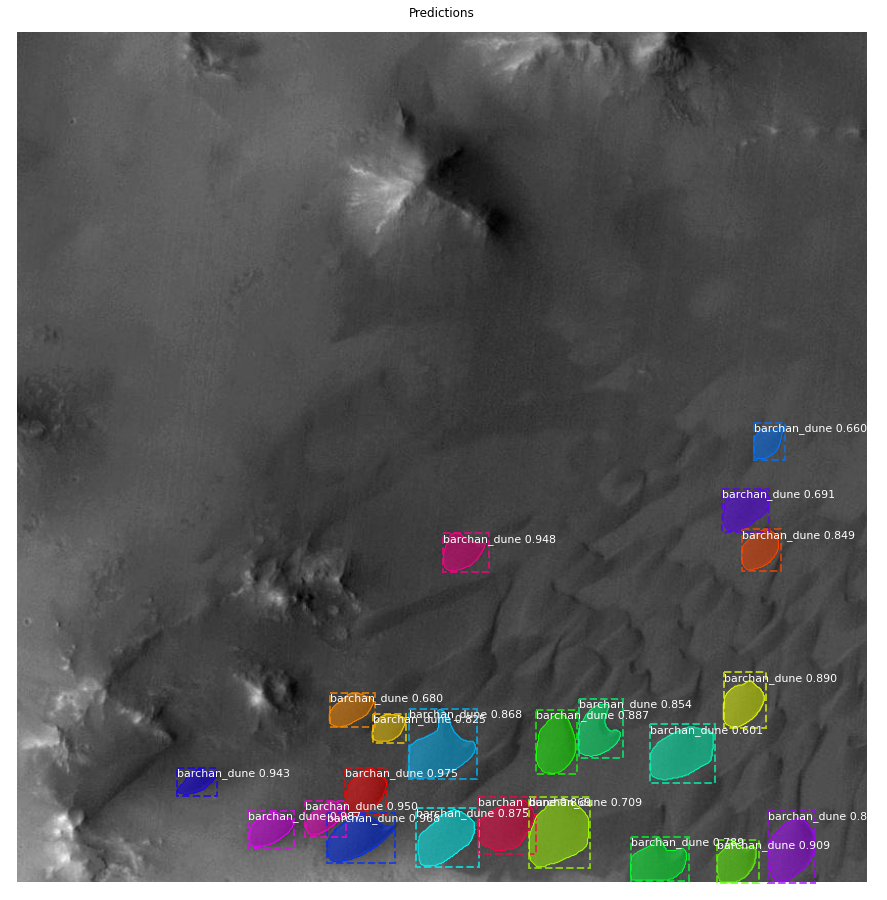

In [17]:
image_id = 12#random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [17]:
print(np.median(AP_list))

0.75


Processing 1 images
image                    shape: (832, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -112.00000  max:  143.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.21783  max:    1.14082  float32
gt_class_id              shape: (8,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (8, 4)                min:   83.00000  max:  832.00000  int32
gt_mask                  shape: (832, 832, 8)         min:    0.00000  max:    1.00000  float64


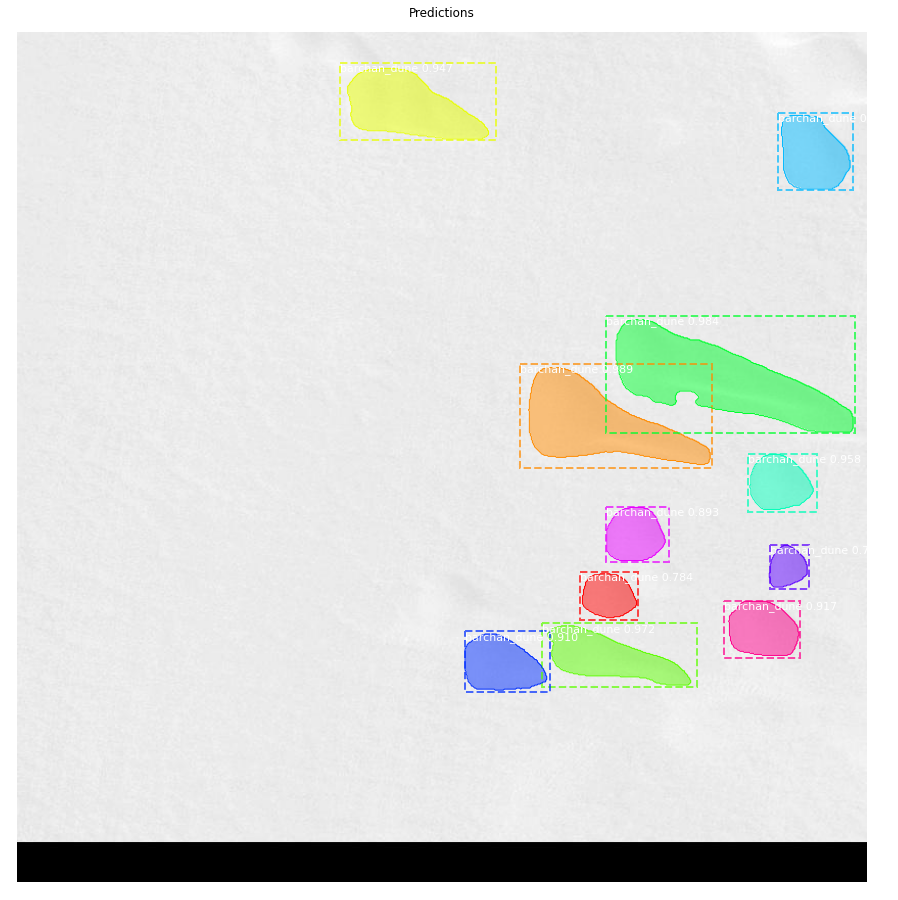

In [19]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, 0, use_mini_mask=False)
info = dataset.image_info[0]



results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

Processing 1 images
image                    shape: (832, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -112.00000  max:  143.00000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.21783  max:    1.14082  float32


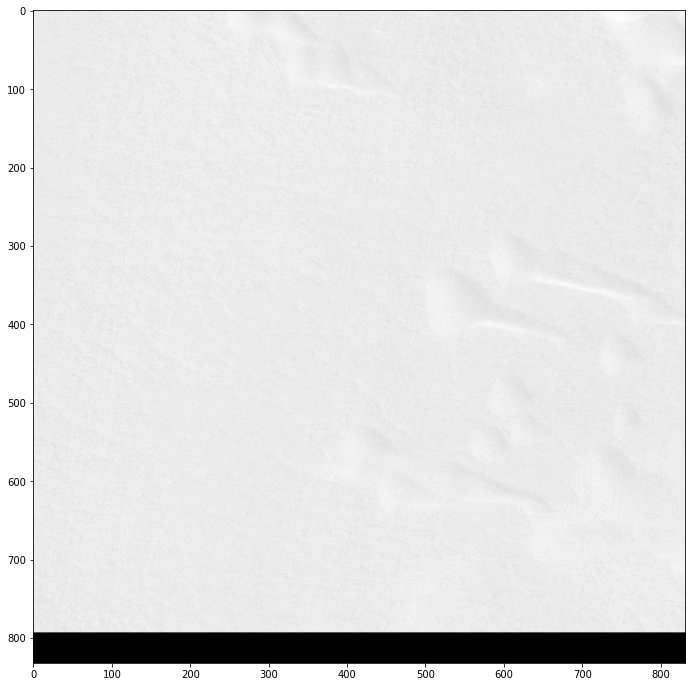

In [24]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, 0, use_mini_mask=False)
info = dataset.image_info[0]



results = model.detect([image], verbose=1)
_, ax = pp.subplots(figsize=(12, 12))
ax.imshow(image)

Restoring detections from file.


HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1400, in H5F__open
    unable to open file
  File "H5Fint.c", line 1700, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 623, in H5F__super_read
    truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048

End of HDF5 error back trace

Unable to open/create file '/data2/lapotre/liorr/detection_results/predictions_df.hdf5'

In [87]:
si = subimg[0]
si = si[:,:,np.newaxis]
np.shape(si)

(832, 832, 1)